# Выбор локации для скважины

## Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Шаги для выбора локации обычно такие:

1. В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
2. Строят модель для предсказания объёма запасов в новых скважинах;
3. Выбирают скважины с самыми высокими оценками значений;
4. Определяют регион с максимальной суммарной прибылью отобранных скважин.

Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

**Условия задачи**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Описание данных

Данные геологоразведки трёх регионов находятся в файлах: 

1. /datasets/geo_data_0.csv. 
2. /datasets/geo_data_1.csv.
3. /datasets/geo_data_2.csv.

id — уникальный идентификатор скважины;
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
product — объём запасов в скважине (тыс. баррелей).

## План работы

#### Шаг 1. Загрузка данных
Загрузим файлы с данными `geo_data_0`, `geo_data_1`, `geo_data_2`

#### Шаг 2. Предобработка данных
Изучим данные, при необходимости выполним предобработку. Если нет, то перейдем к следующему шагу.

#### Шаг 3. Исследовательский анализ данных
Исследуем все признаки и сделаем выводы о том, как их нужно подготовить.

#### Шаг 4. Подготовка данных
Подготовку признаков выполним в пайплайне, дополнив пайплайн шага предобработки. При кодировании учтем особенности признаков и моделей.

#### Шаг 5. Обучение моделей
Обучим модель линейной регрессии, оценим их работу с помощью выбранных по ходу проекта метрик и исходя из вида модели.

#### Шаг 6. Посчитаем прибыль
Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели. Выберем скважины с максимальными значениями предсказаний. 

#### Шаг 7. Проанализируем риски
Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.

#### Шаг 8. Выводы по проекту
Cоберем промежуточные выводы, а затем дадим общие выводы по всему проекту.

## Импорт библиотек и собственные функции

In [1]:
!pip install phik -q
!pip install shap -q
!pip install --upgrade certifi

import pandas as pd
import os
import requests
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from termcolor import colored
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

TEST_SIZE = 0.25
RANDOM_STATE = 42
pd.options.mode.chained_assignment = None
from urllib.request import urlretrieve
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

DEPRECATION: dexplot 0.1.4 has a non-standard dependency specifier scipy>=1.0matplotlib>=3.1. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of dexplot or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: ipykernel 6.0.0 has a non-standard dependency specifier matplotlib-inline<0.2.0appnope,>=0.1.0; platform_system == "Darwin". pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of ipykernel or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: dexplot 0.1.4 has a non-standard dependency specifier scipy>=1.0matplotlib>=3.1. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of dexp

In [2]:
#функция для вывода первичной информации
def quick_info(df_list):
    for df in df_list:
        print(colored('Общая информация:', 'red', attrs=['bold']))
        print(df.info())
        print(colored('Статистика по числовым данным:', 'red', attrs=['bold']))
        print(df.describe())
        print(colored('Дубликаты:', 'red', attrs=['bold']))
        print(df.duplicated().sum())

#функция для построения гистограммы и ящика с усами для каждого количественного признака
def histbox(df, exclude_cols=[], bins=80, normalize=True, figsize=(10, 30), title_fontsize=14, axis_fontsize=12):
    
    #Оставим только количественные признаки и исключим колонки в exclude_cols
    numeric_features = df.drop(columns=exclude_cols).select_dtypes(include=[np.number]).columns.tolist()

    #Определим под сабплоты количество строк и столбцов
    num_rows = len(numeric_features) * 2  #Удвоенное количество строк
    num_cols = 1 

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Гистограммы и ящики с усами
    for i, feature in enumerate(numeric_features):
        row = i * 2  #Перескакиваем через одну строку, чтобы каждая пара графиков оказалась на своем месте
        
        # Гистограмма
        sns.histplot(df[feature], bins=bins, ax=axes[row])
        axes[row].set_title(f'Гистограмма для \n{feature}', fontsize=title_fontsize)
        axes[row].tick_params(axis='both', labelsize=axis_fontsize)

        # Ящик с усами
        sns.boxplot(x=df[feature], ax=axes[row + 1], data=df)
        axes[row].set_title(f'Боксплот для \n{feature}', fontsize=title_fontsize)
        axes[row].tick_params(axis='both', labelsize=axis_fontsize)

    plt.tight_layout()
    plt.show()

    
#функция для разбивки датафрейма на тренировочную, тестовую и валидационную выборку, 
#шкалирования его с MinMaxScaler() и обучения линейной модели
def split_train(data):
    features = data.drop(['product','id'], axis=1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                  target, 
                                                                                  test_size=TEST_SIZE, 
                                                                                  random_state=RANDOM_STATE)
    scaler = MinMaxScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    predictions = pd.Series(predictions)
    RMSE = mean_squared_error(predictions, target_valid,squared=False)
    avg_product = sum(predictions) / len(predictions)
    
    print("RMSE: {0:.2f}".format(RMSE))
    print("Средний запас предсказанного сырья: {0:.2f}".format(avg_product))
    
    return(predictions, target_valid.reset_index(drop=True), RMSE)

def phik_analysis(data):
    data = data.set_index('id')
    df_analysis = data.phik_matrix(verbose=False)
    plot_correlation_matrix(
        df_analysis.values,
        x_labels=df_analysis.columns,
        y_labels=df_analysis.index,
        vmin=0, vmax=1, color_map='Greens',
        title=r'Корреляция $\phi_K$',
        fontsize_factor=1.5,
        figsize=(8, 5)
    )

## Шаг 1. Загрузка и знакомство с данными

In [3]:
pth1_geo_0 = 'https://code.s3.yandex.net/datasets/geo_data_0.csv'
pth2_geo_0 = '/Users/macbookpro/Downloads/geo_data_0.csv'

if os.path.exists(pth2_geo_0):
    geo_0 = pd.read_csv(pth2_geo_0, parse_dates=True)
else:
    try:
        urlretrieve(pth1_geo_0, pth2_geo_0)
        geo_0 = pd.read_csv(pth2_geo_0, parse_dates=True)
    except Exception as e:
        print('Something is wrong:', e)

pth1_geo_1 = 'https://code.s3.yandex.net/datasets/geo_data_1.csv'
pth2_geo_1 = '/Users/macbookpro/Downloads/geo_data_1.csv'

if os.path.exists(pth2_geo_1):
    geo_1 = pd.read_csv(pth2_geo_1, parse_dates=True)
else:
    try:
        urlretrieve(pth1_geo_1, pth2_geo_1)
        geo_1 = pd.read_csv(pth2_geo_1, parse_dates=True)
    except Exception as e:
        print('Something is wrong:', e)

pth1_geo_2 = 'https://code.s3.yandex.net/datasets/geo_data_2.csv'
pth2_geo_2 = '/Users/macbookpro/Downloads/geo_data_2.csv'

if os.path.exists(pth2_geo_2):
    geo_2 = pd.read_csv(pth2_geo_2, parse_dates=True)
else:
    try:
        urlretrieve(pth1_geo_2, pth2_geo_2)
        geo_2 = pd.read_csv(pth2_geo_2, parse_dates=True)
    except Exception as e:
        print('Something is wrong:', e)

Посмотрим на основную информацию по нашим датафреймам с помощью ранее созданной функции quick_info():

In [4]:
all_df = [geo_0, geo_1, geo_2]

quick_info(all_df)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
Статистика по числовым данным:
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088

Посмотрим, все ли записи уникальные в датафреймах, с помощью проверки уникальности `id`:

In [5]:
i = 0
for df in all_df:
    i += 1
    print(colored(f'Количество уникальных id в датафрейме, регион {i}: {df.value_counts().sum()}', 'red', attrs=['bold']))

Количество уникальных id в датафрейме, регион 1: 100000
Количество уникальных id в датафрейме, регион 2: 100000
Количество уникальных id в датафрейме, регион 3: 100000


### Выводы:

`geo_0`:

- В датафрейме пять колонок, названия которых приведены к "змеиному" регистру, и 10000 строк.
- Данные датафрейма соответствуют своему типу.
- Пропусков и очевидных дубликатов нет.
- Стандартные отклонения по признакам здесь минимальные к датафреймам с двумя другими регионами.

`geo_1`:

- В датафрейме пять колонок, названия которых приведены к "змеиному" регистру, и 10000 строк.
- Данные датафрейма соответствуют своему типу.
- Пропусков и очевидных дубликатов нет.
- Стандартные отклонения больше, чем в датафрейме с первым регионом. Больше и максимальные значения по первым двум признакам нефти.

`geo_2`:

- В датафрейме пять колонок, названия которых приведены к "змеиному" регистру, и 10000 строк.
- Данные датафрейма соответствуют своему типу.
- Пропусков и очевидных дубликатов нет.
- Стандартные отклонения меньше, чем в датафрейме со вторым регионом. Меньше и максимальные значения по первым двум признакам нефти.


## Шаг 2. Предобработка данных

В рамках предыдущего шага мы убедились, что предобработка данных не потребуется:

- нет пропусков;
- нет дубликатов;
- названия колонок соответствуют змеиному регистру.

Перейдем к исследовательскому анализу данных: попробуем установить, есть ли аномальные значения в признаках или иные шумы в данных, которые могут помешать нам и снизить качество работы модели.

## Шаг 3. Исследовательский анализ данных

Проведем исследовательский анализ числовых данных в `geo_0`:

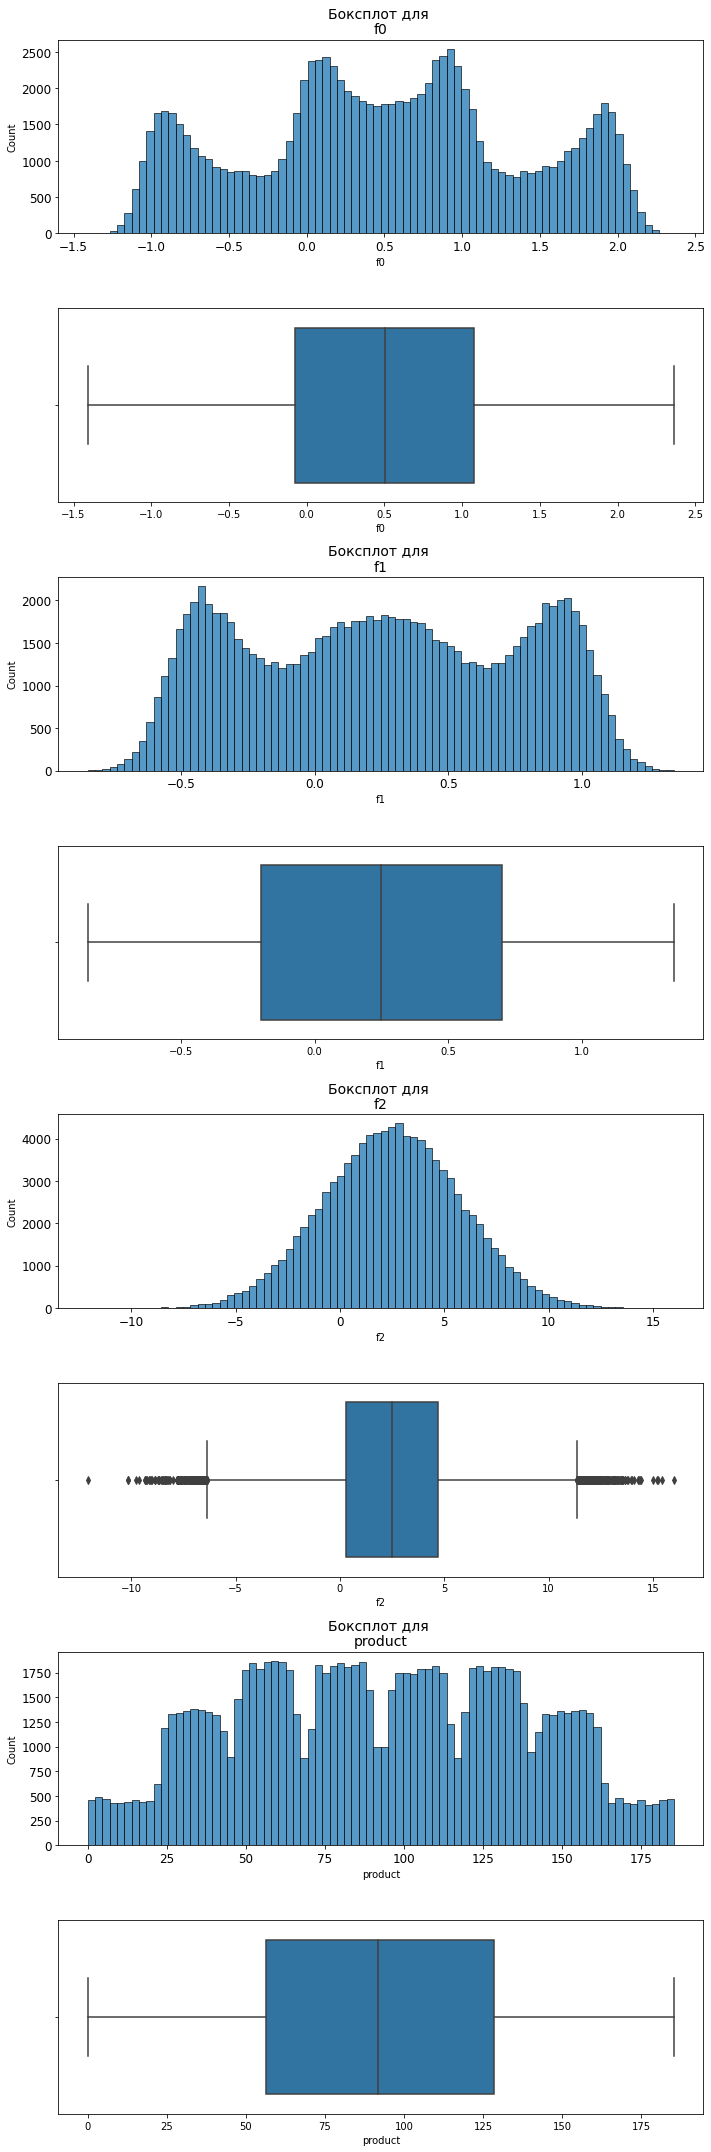

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [6]:
histbox(geo_0, exclude_cols=['id'])
geo_0.describe()

### Промежуточные выводы по распределению числовых признаков `geo_0`:

- **f0**: ненормальное мультимодальное распределение. Среднее  0.5, медиана 0.502, min -1.409, max 2.362. Аномалий по боксплоту не видим.

- **f1**: ненормальное мультимодальное распределение. Среднее  0.2501, медиана 0.2502, min -0.848, max 2.362. Аномалий по боксплоту не видим.

- **f2**: распределение, близкое к нормальному, со сдвигом вправо. Среднее 2.502, медиана 2.516, min -12.088, max 16.003. Аномалии по боксплоту начинаются после значений меньше -6 и больше 11.

- **product**: ненормальное распределение, которое стремится к дискретному. Среднее 92.5, медиана 91.84, min 0, max 185.36.

Повторим анализ для датафрейма `geo_1`:

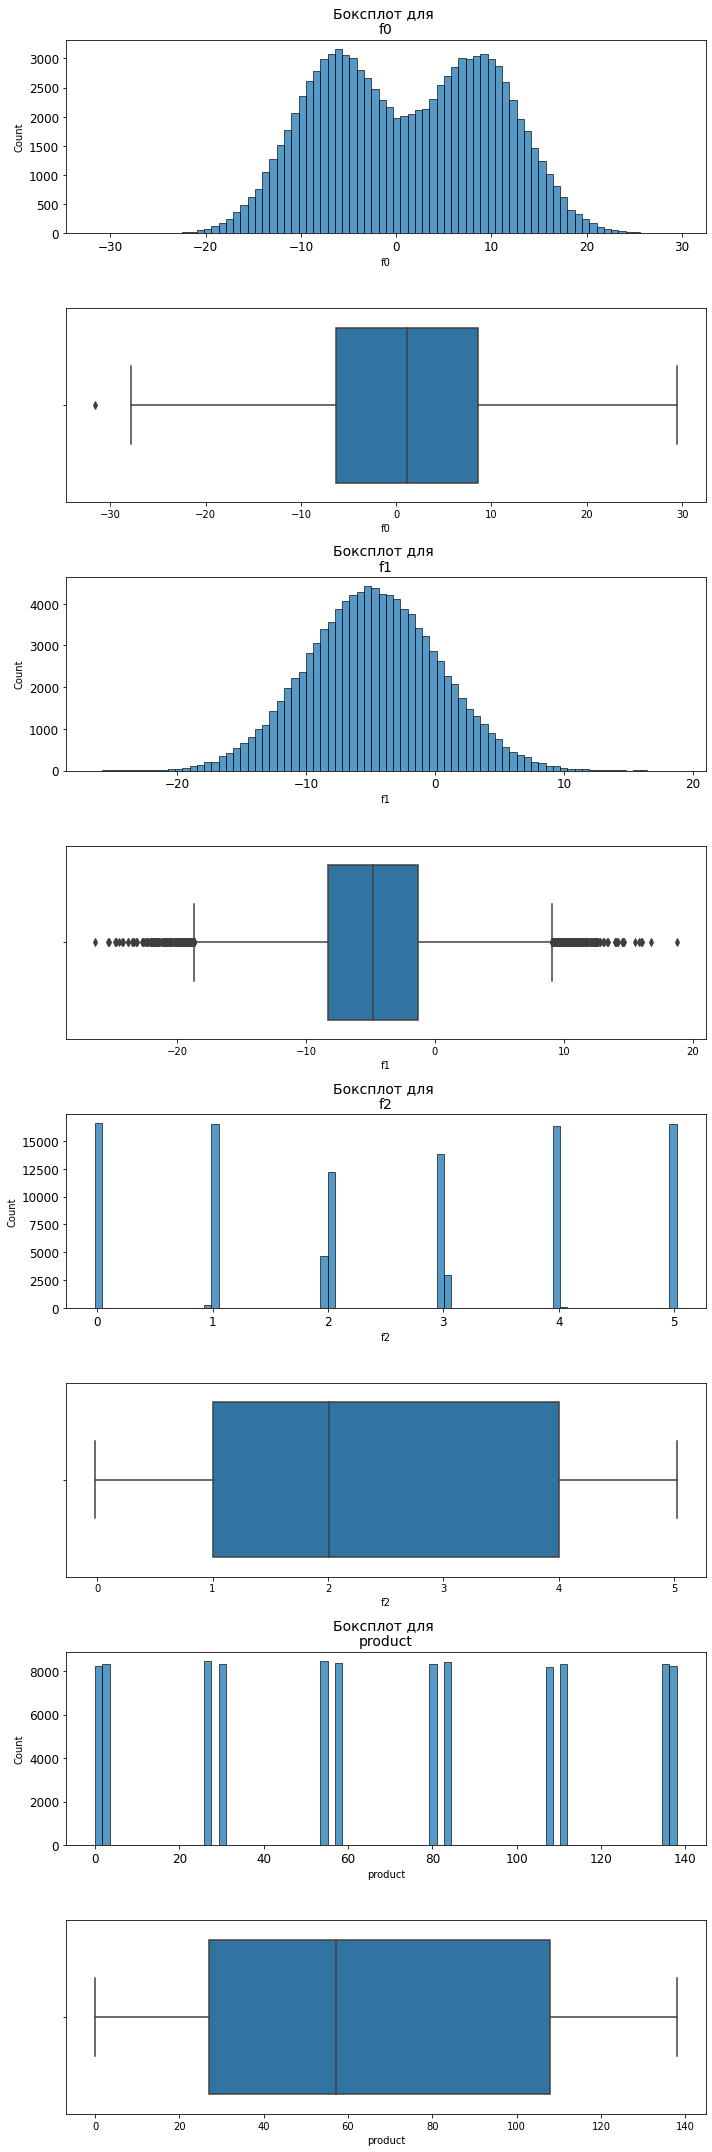

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [7]:
histbox(geo_1, exclude_cols=['id'])
geo_1.describe()

### Промежуточные выводы по распределению числовых признаков `geo_1`:

- **f0**: ненормальное мультимодальное распределение с двумя пиками. Среднее  1.141, медиана 1.153, min -31.609, max 29.421. Аномалии наблюдаем у значений меньше -29.

- **f1**: распределение, близкое к нормальному, со сдвигом влево. Среднее  -4.796, медиана -4.813, min -26.358, max 18.734. Аномалии по боксплоту наблюдаем после значений меньше -19 и больше 9.

- **f2**: ненормальное распределение, которое стремится к дискретному. Среднее 2.494, медиана 2.011, min -0.018, max 5.019. Аномалии по боксплоту не наблюдаем.

- **product**: ненормальное распределение, которое стремится к дискретному. Среднее 68.825, медиана 57.085, min 0, max 137.945.

Повторим анализ для датафрейма `geo_2`:

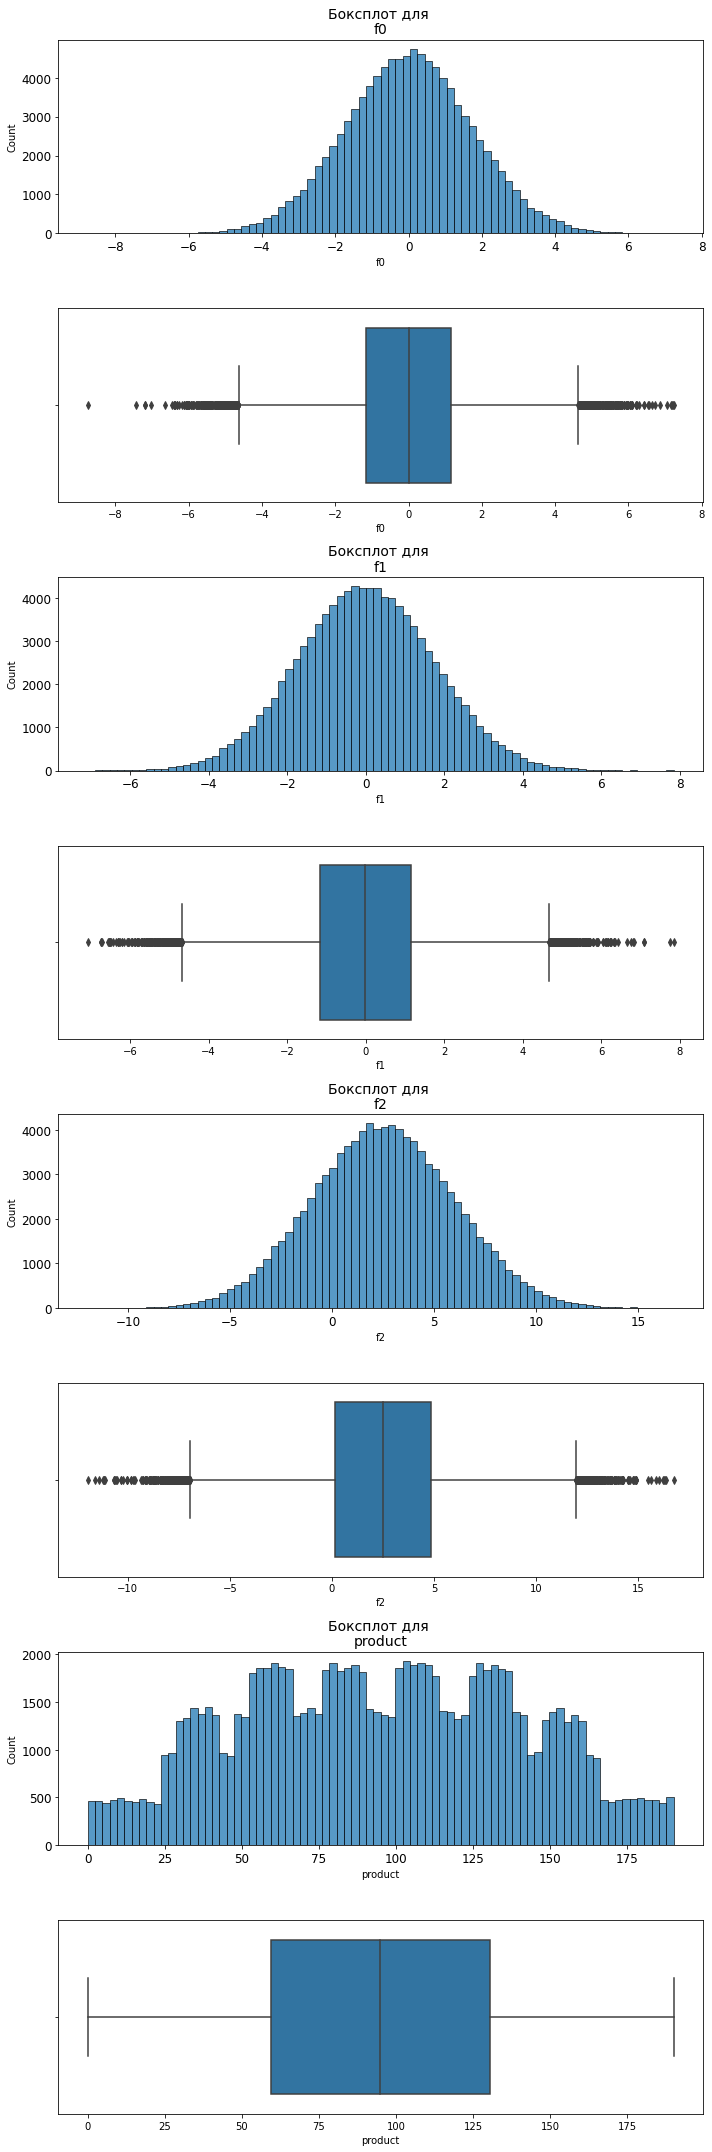

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [8]:
histbox(geo_2, exclude_cols=['id'])
geo_2.describe()

### Промежуточные выводы по распределению числовых признаков `geo_2`:

- **f0**: распределение, близкое к нормальному, со сдвигом вправо. Среднее  0.002, медиана 0.009, min -8.76, max 7.238. Аномалии наблюдаем у значений меньше -4 и больше 4.

- **f1**: распределение, близкое к нормальному, со сдвигом влево. Среднее  -0.002, медиана -0.009, min -7.084, max 7.844. Аномалии по боксплоту наблюдаем у значений меньше -5 и больше 5.

- **f2**: распределение, близкое к нормальному, со сдвигом вправо. Среднее 2.495, медиана 2.484, min -11.97, max 16.739. Аномалии по боксплоту наблюдаем у значений меньше -5 и больше 12.

- **product**: ненормальное распределение, которое стремится к дискретному. Среднее 95, медиана 94.925, min 0, max 190.029.

Перед подготовкой данных и обучением моделей используем библиотеку phik для подсчёта корреляции между признаками разных типов данных в датафреймах по трем регионам:

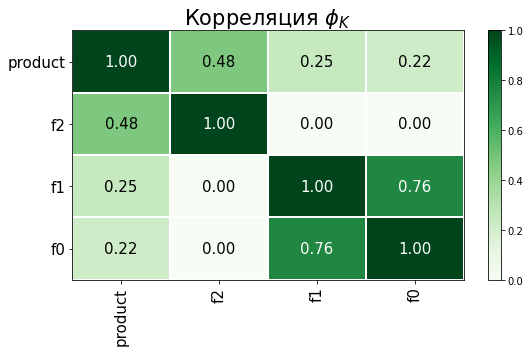

In [9]:
phik_analysis(geo_0)

Видим, что мультиколлинеарности признаков нет: считали бы ее при коллинеарности между признаками от 0.9 и выше. При этом: 

- высокая корреляция есть между признаками f1 и f0: 0.76
- заметная корреляция есть между признаками f2 и product: 0.48

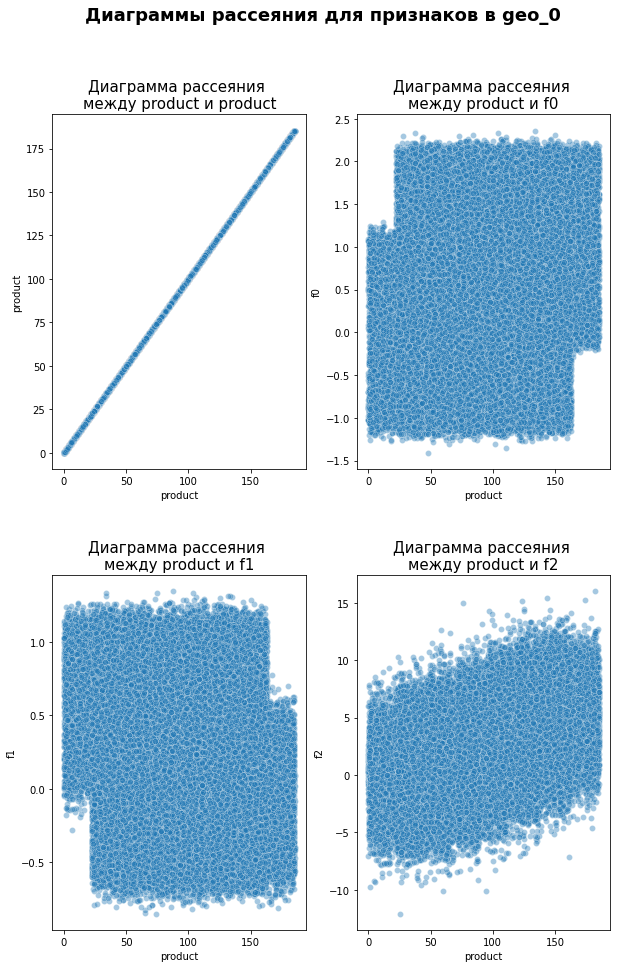

In [10]:
#создадим список с нужными колонками 
columns_relation = geo_0[['product', 'f0', 'f1', 'f2']]

#параметры визуализации                            
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 15))
plt.subplots_adjust(hspace=0.3)
fig.suptitle("Диаграммы рассеяния для признаков в geo_0", fontsize=18, fontweight='bold')

#соберем цикл, который будет искать нужные значения из списка в срезе и строить по ним графики:
for n, col in enumerate(columns_relation):
    ax = plt.subplot(2, 2, n + 1)
    sns.scatterplot(x=geo_0['product'], y= geo_0[col], alpha=0.4, palette='deep')
    plt.title(f'Диаграмма рассеяния \nмежду product и {col}', fontsize=15)

Не видим признаков нелинейной связи между признаками и product: отмечается выраженная линейная зависимость между product и f2 в geo_0.

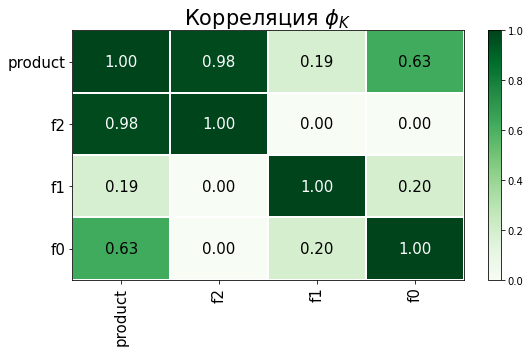

In [11]:
phik_analysis(geo_1)

Видим, что мультиколлинеарность признаков есть между f2 и product (0.98). Еще заметная корреляция есть между f0 и product (0.63). 

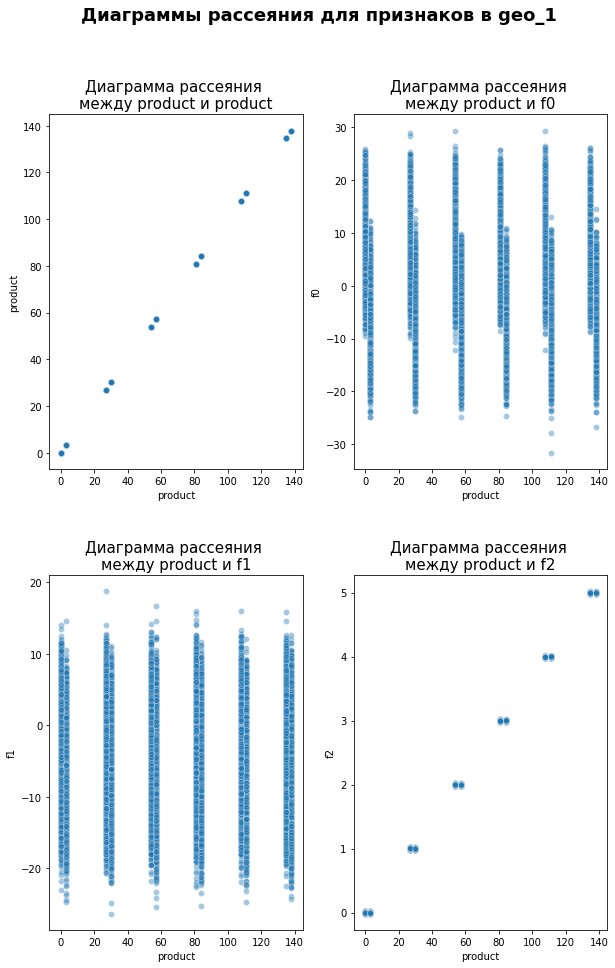

In [12]:
#создадим список с нужными колонками 
columns_relation = geo_1[['product', 'f0', 'f1', 'f2']]

#параметры визуализации                            
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 15))
plt.subplots_adjust(hspace=0.3)
fig.suptitle("Диаграммы рассеяния для признаков в geo_1", fontsize=18, fontweight='bold')

#соберем цикл, который будет искать нужные значения из списка в срезе и строить по ним графики:
for n, col in enumerate(columns_relation):
    ax = plt.subplot(2, 2, n + 1)
    sns.scatterplot(x=geo_1['product'], y= geo_1[col], alpha=0.4, palette='deep')
    plt.title(f'Диаграмма рассеяния \nмежду product и {col}', fontsize=15)

Снова не видим наличие нелинейных взаимосвязей в geo_1, только выраженную линейную связь между product и f2.

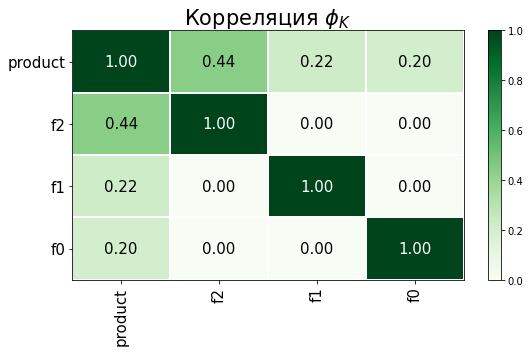

In [13]:
phik_analysis(geo_2)

Видим, что мультиколлинеарности между признаками нет. Есть заметная корреляция между f2 и product (0.44).

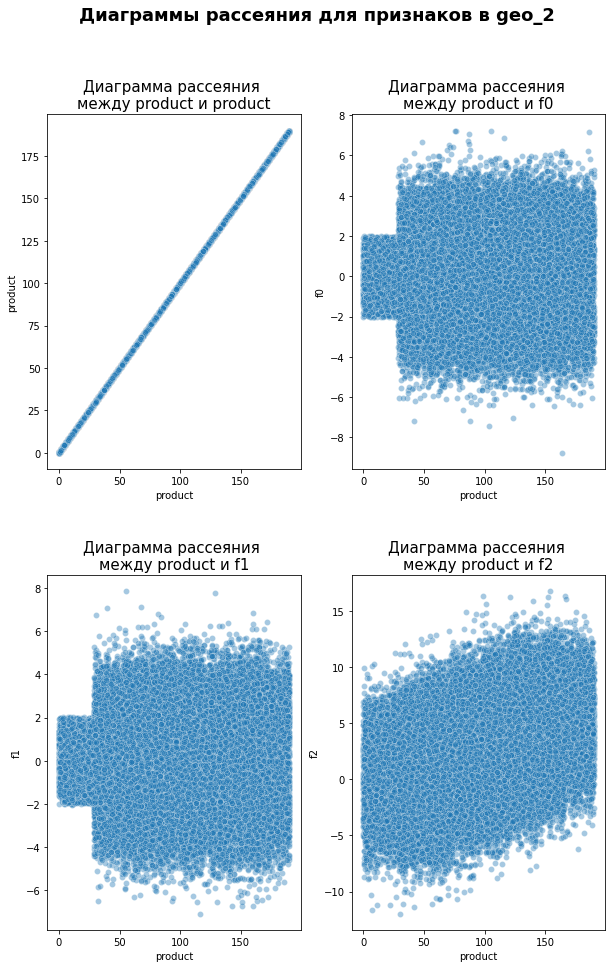

In [14]:
#создадим список с нужными колонками 
columns_relation = geo_2[['product', 'f0', 'f1', 'f2']]

#параметры визуализации                            
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 15))
plt.subplots_adjust(hspace=0.3)
fig.suptitle("Диаграммы рассеяния для признаков в geo_2", fontsize=18, fontweight='bold')

#соберем цикл, который будет искать нужные значения из списка в срезе и строить по ним графики:
for n, col in enumerate(columns_relation):
    ax = plt.subplot(2, 2, n + 1)
    sns.scatterplot(x=geo_2['product'], y= geo_2[col], alpha=0.4, palette='deep')
    plt.title(f'Диаграмма рассеяния \nмежду product и {col}', fontsize=15)

Видим выраженную линейную зависимость между product и f2.

### Выводы:

Изучили, визуализировали и описали числовые признаки в имеющихся датафреймах с помощью гистограмм и боксплотов.

1. `geo_0`:

- **f0**: ненормальное мультимодальное распределение. Среднее  0.5, медиана 0.502, min -1.409, max 2.362. Аномалий по боксплоту не видим.

- **f1**: ненормальное мультимодальное распределение. Среднее  0.2501, медиана 0.2502, min -0.848, max 2.362. Аномалий по боксплоту не видим.

- **f2**: распределение, близкое к нормальному, со сдвигом вправо. Среднее 2.502, медиана 2.516, min -12.088, max 16.003. Аномалии по боксплоту начинаются после значений меньше -6 и больше 11.

- **product**: ненормальное распределение со сдвигом вправо. Среднее 92.5, медиана 91.84, min 0, max 185.36.

2. `geo_1`:

- **f0**: ненормальное мультимодальное распределение с двумя пиками. Среднее  1.141, медиана 1.153, min -31.609, max 29.421. Аномалии наблюдаем у значений меньше -29.

- **f1**: распределение, близкое к нормальному, со сдвигом влево. Среднее  -4.796, медиана -4.813, min -26.358, max 18.734. Аномалии по боксплоту наблюдаем после значений меньше -19 и больше 9.

- **f2**: ненормальное распределение, которое стремится к дискретному. Среднее 2.494, медиана 2.011, min -0.018, max 5.019. Аномалии по боксплоту не наблюдаем.

- **product**: ненормальное распределение, которое стремится к дискретному. Среднее 68.825, медиана 57.085, min 0, max 137.945.

3. `geo_2`:

- **f0**: распределение, близкое к нормальному, со сдвигом вправо. Среднее  0.002, медиана 0.009, min -8.76, max 7.238. Аномалии наблюдаем у значений меньше -4 и больше 4.

- **f1**: распределение, близкое к нормальному, со сдвигом влево. Среднее  -0.002, медиана -0.009, min -7.084, max 7.844. Аномалии по боксплоту наблюдаем у значений меньше -5 и больше 5.

- **f2**: распределение, близкое к нормальному, со сдвигом вправо. Среднее 2.495, медиана 2.484, min -11.97, max 16.739. Аномалии по боксплоту наблюдаем у значений меньше -5 и больше 12.

- **product**: ненормальное распределение, которое стремится к дискретному. Среднее 95, медиана 94.925, min 0, max 190.029.

Для признаков с нарушениями и повышениями можно взять метод OneHotEncoder, для остальных признаков OrdinalEncoder. 

Кроме того, с помощью библиотеки phik выявили, что мультиколлинеарность есть в geo_1 между f2 и product (0.98).

## Шаг 4-5. Подготовка данных и обучение модели

С помощью заранее подготовленной функции split_train() разделим данные в трех датафреймах на три выборки (тестовая, обучающая и валидационная). Затем прошкалируем наши числовые данные с помощью MinMaxScaler() внутри функции и обучим модель линейной регрессии для трех регионов. Выведем показатели метрики RMSE и средний запас предсказанного сырья для каждого из регионов: 

In [15]:
i = 0
for region in [geo_0, geo_1, geo_2]:
    i += 1
    print(colored(f'Предсказанные данные, регион {i}:', 'red', attrs=['bold']))
    split_train(region)

Предсказанные данные, регион 1:
RMSE: 37.76
Средний запас предсказанного сырья: 92.40
Предсказанные данные, регион 2:
RMSE: 0.89
Средний запас предсказанного сырья: 68.71
Предсказанные данные, регион 3:
RMSE: 40.15
Средний запас предсказанного сырья: 94.77


### Выводы:

- Регион 1:
RMSE довольно высок по сравнению со вторым регионом, 37.76. Средний запас предсказанного сырья в этом регионе составляет примерно 92.4 тысячи баррелей.

- Регион 2
Здесь видим очень низкий показатель по RMSE, всего 0.89, что указывает на то, что прогнозируемые значения близки к фактическим. Средний запас предсказанного сырья в этом регионе составляет 68.71 тысячу баррелей.

- Регион 3
Здесь RMSE составляет 40.15. Это наибольшее значение из данных по предоставленным регионам. Средний запас предсказанного сырья в этом регионе самый высокий: примерно 94.77 тысячи баррелей.

Регион 2 представляет собой наиболее надежный для разработки, так как у него самое низкое значение RMSE и при этом достаточно высокий средний запас предсказанного сырья.

## Шаг 6. Посчитаем прибыль

Сперва сохраним все ключевые значения для расчётов в отдельных переменных:

In [16]:
pred_0, val_0, rmse_0 = split_train(geo_0)
pred_1, val_1, rmse_1 = split_train(geo_1)
pred_2, val_2, rmse_2 = split_train(geo_2)

RMSE: 37.76
Средний запас предсказанного сырья: 92.40
RMSE: 0.89
Средний запас предсказанного сырья: 68.71
RMSE: 40.15
Средний запас предсказанного сырья: 94.77


**Вспомним условия задачи:**
    
1. Бюджет на разработку скважин в регионе — 10 млрд рублей.
2. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
3. После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Сперва посчитаем, какой объем сырья должен быть в скважинах региона, чтобы выйти на безубыточность при разработке: 

In [17]:
TOTAL_BUDGET = 10 ** 10
PRODUCT_1 = 450000
DIVIDE = TOTAL_BUDGET / PRODUCT_1
print('Достаточный объём сырья для безубыточной разработки новых скважин в регионе: {0:.2f}'.format(DIVIDE))

Достаточный объём сырья для безубыточной разработки новых скважин в регионе: 22222.22


Мы видим, что для окупаемости разработки новых скважин в регионе объем сырья в них должен быть не менее 22.2 тысяч баррелей. Вспомним другое условие: при разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки. 

Посчитаем средний предполагаемый достаточный объем сырья в одной скважине в регионе: 

In [18]:
DIVIDE_1 = np.ceil(DIVIDE/200)
print(f'Достаточный объём сырья для безубыточной разработки в одной скважине в регионе:', DIVIDE_1)

Достаточный объём сырья для безубыточной разработки в одной скважине в регионе: 112.0


Ни один из регионов по этому условию не подходит для безубыточной разработки: ближе всего третий регион со средним объемом сырья в одной скважине в 94 барреля. Тем не менее, при выборе любого из трех регионов сохранятся риски, что разработка не окупится. Поэтому нам нужны модели, чтобы сократить степень этих рисков и подобрать наиболее подходящие скважины.

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

In [19]:
target_0 = geo_0['product']
target_1 = geo_1['product']
target_2 = geo_2['product']

def evaluate_regions(pred_0, target_0, pred_1, target_1, pred_2, target_2, total_budget, product_1):
    def profit(predict, target, count):
        probs_sorted = pd.Series(predict, index=target.index).sort_values(ascending=False)
        selected_max = probs_sorted[:count].sum()
        return selected_max

    #1. Рассчитаем суммарный запас сырья в 200 лучших скважинах для каждого региона
    profit_1 = profit(pred_0, target_0, count=200)
    profit_2 = profit(pred_1, target_1, count=200)
    profit_3 = profit(pred_2, target_2, count=200)

    #2. Вычислим прибыль для каждого региона
    profit_total_1 = (profit_1 * product_1) - total_budget
    profit_total_2 = (profit_2 * product_1) - total_budget
    profit_total_3 = (profit_3 * product_1) - total_budget
    
    print('Регион 1:')
    print('Суммарный запас сырья в 200 лучших скважинах: {0:.2f}'.format(profit_1))
    print('Прибыль: {0:.2f}'.format(profit_total_1))
    
    print('\nРегион 2:')
    print('Суммарный запас сырья в 200 лучших скважинах: {0:.2f}'.format(profit_2))
    print('Прибыль: {0:.2f}'.format(profit_total_2))
    print('\nРегион 3:')
    print('Суммарный запас сырья в 200 лучших скважинах: {0:.2f}'.format(profit_3))
    print('Прибыль: {0:.2f}'.format(profit_total_3))


In [20]:
evaluate_regions(pred_0, target_0, pred_1, target_1, pred_2, target_2, TOTAL_BUDGET, PRODUCT_1)

Регион 1:
Суммарный запас сырья в 200 лучших скважинах: 30881.46
Прибыль: 3896658479.67

Регион 2:
Суммарный запас сырья в 200 лучших скважинах: 27748.75
Прибыль: 2486938115.00

Регион 3:
Суммарный запас сырья в 200 лучших скважинах: 29728.85
Прибыль: 3377981513.71


### Выводы:

Мы видим, что все регионы потенциально пока проходят исходя из наших условий: есть высокий суммарный запас сырья в 200 лучших скважинах и высокая потенциальная прибыль после вычета расходов. Следующим шагом проведем расчет вероятности и рисков, чтобы выявить наиболее подходящий для наших целей регион.

## Шаг 7. Посчитаем риски и доверительный интервал по прибыли 

Посчитаем риски и прибыль для каждого региона. Для этого применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Еще посчитаем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Будем помнить, что убыток — это отрицательная прибыль.

In [21]:
def profit_1(predict, target, count):
    top_preds = predict.sort_values(ascending=False)
    top_target = target[top_preds.index][:200]
    revenue = top_target.sum() * PRODUCT_1
    return revenue - TOTAL_BUDGET

def bootstrap_1000(target, predict):
    values = []
    count = 0
    state = np.random.RandomState(12345)
    predict_e = pd.Series(predict, index=target.index)

    for _ in tqdm(range(1000)):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        probs_subsample = predict_e[target_subsample.index]
        values.append(profit_1(probs_subsample, target_subsample, 200))
        
    values = pd.Series(values)
    mean = values.mean()
    confidence_interval = st.t.interval(0.95, len(values)-1, mean, st.sem(values))

    plt.figure(figsize=(8, 5))
    plt.hist(values, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title('Распределение прибыли')
    plt.xlabel('Прибыль, тыс. руб.')
    plt.ylabel('Количество')
    plt.grid(True)
    plt.axvline(x=mean, color='red', linestyle='--', label='Среднее значение')
    plt.axvline(x=confidence_interval[0], color='green', linestyle=':', label='Нижняя граница 95% интервала')
    plt.axvline(x=confidence_interval[1], color='green', linestyle=':', label='Верхняя граница 95% интервала')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()
    
    low_95 = values.quantile(0.025)
    high_95 = values.quantile(0.975)
    risk = np.mean(values < 0) * 100
    
    print('Средняя прибыль: {:.2f} млн. руб.'.format(mean / 1000))
    print('95% доверительный интервал от {:.2f} млн. руб. до {:.2f} млн. руб.'.format(confidence_interval[0] / 1000, confidence_interval[1] / 1000))
    print('С вероятностью 95% прибыль в данном регионе будет составлять от: {:.2f} млн. руб. до: {:.2f} млн. руб.'.format(low_95 / 1000, high_95 / 1000))
    print('Вероятность убытка в регионе: {:.1f}%'.format(risk))

  0%|          | 0/1000 [00:00<?, ?it/s]

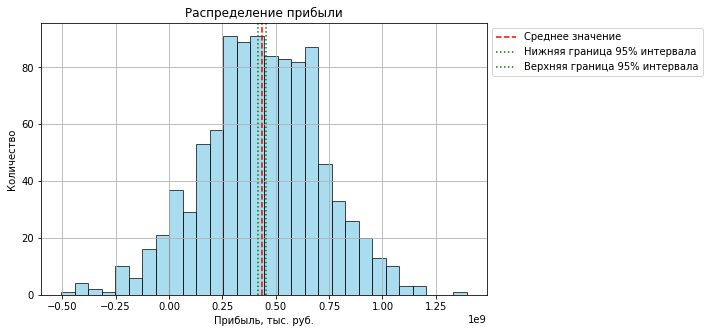

Средняя прибыль: 435933.77 млн. руб.
95% доверительный интервал от 418761.10 млн. руб. до 453106.44 млн. руб.
С вероятностью 95% прибыль в данном регионе будет составлять от: -116231.61 млн. руб. до: 966504.18 млн. руб.
Вероятность убытка в регионе: 6.1%


In [22]:
bootstrap_1000(val_0, pred_0)

  0%|          | 0/1000 [00:00<?, ?it/s]

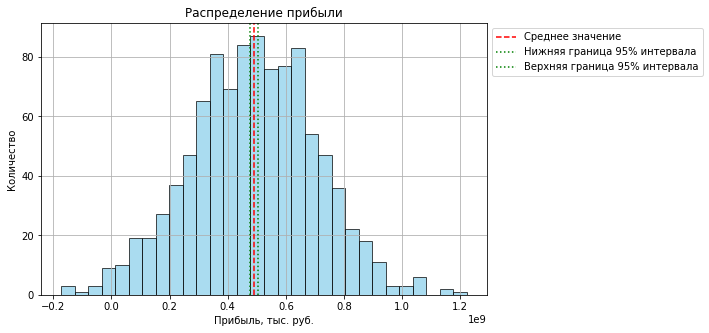

Средняя прибыль: 489661.25 млн. руб.
95% доверительный интервал от 476234.87 млн. руб. до 503087.64 млн. руб.
С вероятностью 95% прибыль в данном регионе будет составлять от: 55116.18 млн. руб. до: 905762.65 млн. руб.
Вероятность убытка в регионе: 1.1%


In [23]:
bootstrap_1000(val_1, pred_1)

  0%|          | 0/1000 [00:00<?, ?it/s]

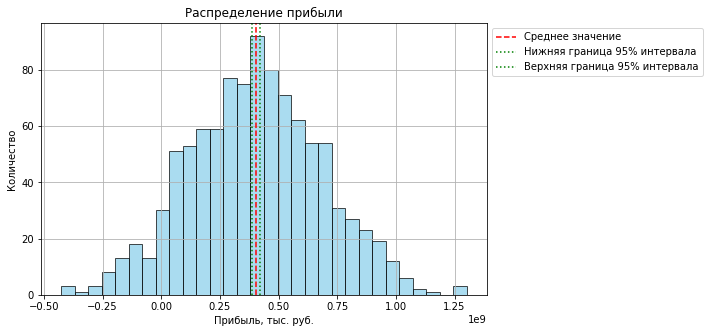

Средняя прибыль: 403687.93 млн. руб.
95% доверительный интервал от 386206.71 млн. руб. до 421169.14 млн. руб.
С вероятностью 95% прибыль в данном регионе будет составлять от: -153116.98 млн. руб. до: 952887.42 млн. руб.
Вероятность убытка в регионе: 7.1%


In [24]:
bootstrap_1000(val_2, pred_2)

### Выводы:

1) `1-ый регион`

Этот регион не проходит по условиям задачи: уровень риска здесь выше 2.5%, несмотря на то, что есть запасы сырья и хорошие показатели по средней прибыли. 

2) `2-ой регион`

Несмотря на то, что во втором регионе был самый небольшой суммарный запас сырья среди всех регионов, именно он с точки зрения риска является наиболее выигрышным. Вероятность убытка в регионе составляет 1.1%, 95%-ный доверительный интервал по прибыли: от 476234.87 млн. руб. до 503087.64 млн. руб.

3) `3-ий регион`

Как и 1-ый, этот регион не подойдет для дальнейшей работы с точки зрения уровня риска. При этом 95%-ный доверительный интервал по прибыли: от 386206.71 млн. руб. до 421169.14 млн. руб.

## Шаг 8. Выводы по проекту

- В ходе работы над проектом мы решили поставленную задачу: дали рекомендации, в каком из трех предоставленных регионов стоит бурить скважины.

Вот что для этого сделали:

1. Загрузили `geo_0`: в датафрейме пять колонок, названия которых приведены к "змеиному" регистру, и 10000 строк. Данные датафрейма соответствуют своему типу. Пропусков и очевидных дубликатов нет. Стандартные отклонения по признакам здесь минимальные к датафреймам с двумя другими регионами.


2. Загрузили `geo_1`: в датафрейме пять колонок, названия которых приведены к "змеиному" регистру, и 10000 строк. Данные датафрейма соответствуют своему типу. Пропусков и очевидных дубликатов нет. Стандартные отклонения больше, чем в датафрейме с первым регионом. Больше и максимальные значения по первым двум признакам нефти.


3. Загрузили `geo_2`: в датафрейме пять колонок, названия которых приведены к "змеиному" регистру, и 10000 строк. Данные датафрейма соответствуют своему типу. Пропусков и очевидных дубликатов нет. Стандартные отклонения меньше, чем в датафрейме со вторым регионом. Меньше и максимальные значения по первым двум признакам нефти.


4. Дополнительная предобработка данных не потребовалась, поэтому перешли к исследовательскому анализу.


5. В рамках исследовательского анализ посмотрели распределение числовых признаках во всех таблицах, выявили, что особых выбросов нет, да и утечку целевого признака не обнаружили. Изучили, визуализировали и описали признаки с помощью гистограмм и боксплотов.


6. Подготовили данные (масштабирование). Взяли модель линейной регрессии, обучили ее. Вот что получили:


1. `geo_0`: RMSE довольно высок по сравнению со вторым регионом, 37.76. Средний запас предсказанного сырья в этом регионе составляет примерно 92.4 тысячи баррелей.

2. `geo_1`: Здесь видим очень низкий показатель по RMSE, всего 0.89, что указывает на то, что прогнозируемые значения близки к фактическим. Средний запас предсказанного сырья в этом регионе составляет 68.71 тысячу баррелей.

3. `geo_2`: Здесь RMSE составляет 40.15. Это наибольшее значение из данных по предоставленным регионам. Средний запас предсказанного сырья в этом регионе самый высокий: примерно 94.77 тысячи баррелей.


Регион 2 представляет собой наиболее надежный для разработки, так как у него самое низкое значение RMSE и при этом достаточно высокий средний запас предсказанного сырья.


7. Посчитали, какой объем сырья должен быть в скважинах региона, чтобы выйти на безубыточность при разработке. Суммарный объем сырья в них должен быть не менее 22.2 тысяч баррелей.


8. Посчитали риски и прибыль для каждого региона. Для этого применили технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Еще посчитали среднюю прибыль, 95%-й доверительный интервал и риск убытков:


1. `geo_0`: Средняя прибыль: 435933.77 млн. руб. 95% доверительный интервал от 418761.10 млн. руб. до 453106.44 млн. руб. С вероятностью 95% прибыль в данном регионе будет составлять от: -116231.61 млн. руб. до: 966504.18 млн. руб. Вероятность убытка в регионе: 6.1%


2. `geo_1`: Средняя прибыль: 489661.25 млн. руб. 95% доверительный интервал от 476234.87 млн. руб. до 503087.64 млн. руб. С вероятностью 95% прибыль в данном регионе будет составлять от: 55116.18 млн. руб. до: 905762.65 млн. руб. Вероятность убытка в регионе: 1.1%


3. `geo_2`: Средняя прибыль: 403687.93 млн. руб. 95% доверительный интервал от 386206.71 млн. руб. до 421169.14 млн. руб. С вероятностью 95% прибыль в данном регионе будет составлять от: -153116.98 млн. руб. до: 952887.42 млн. руб. Вероятность убытка в регионе: 7.1%


9. Так мы сделали выбор в сторону второго региона `geo_1`. Несмотря на то, что во втором регионе был самый небольшой суммарный запас сырья среди всех регионов, именно он с точки зрения риска является наиболее выигрышным. Вероятность убытка в регионе составляет 1.1%.